<a href="https://colab.research.google.com/github/nverchev/TrueSkill-step-by-step/blob/main/trueskill_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TrueSkill step by step
This notebook guides you through the Trueskill™ algorithm, a rating system developed by Microsoft for the Xbox gaming platform. This implementation is for educational purposes and explains the message-passing algorithm step by step using a traditional Bayesian vocabulary. It is not an implementation designed for efficiency or practical use. Note that the algorithm is under copyrights and that only non-commercial projects can freely use Truskill™.

This implementation adds a variable called "Luck" that replaces the initial convolution of the original algorithm. This modelling choice may be more intuitive to some and is mathematically equivalent. This implementation only covers a basic version of Trueskill with no teams and no game-specific variables. Many online resources explain how to extend it to the general setup and how the matchmaking criteria works. I name a few here:

- The original [paper](https://www.microsoft.com/en-us/research/publication/trueskilltm-a-bayesian-skill-rating-system/) about Trueskill
- The [infopage](https://www.microsoft.com/en-us/research/project/trueskill-ranking-system/) on microsoft.com
- A divulgation [article](http://www.moserware.com/2010/03/computing-your-skill.html), starting with a gentle introduction, by Jeff Moser
- The Python [implementation](https://trueskill.org/) by Heungsub Lee (I used this to check my code)
- Chapter 3 [Meeting your match](https://mbmlbook.com/TrueSkill.html) from Model-Based Machine Learning by John Winn

This notebook reproduces the examplein the last resource. We start by updating the ratings of Jill and Fred after their game. Then, we show how the multiplayer setting works by letting Steve join them in a new game.

This implementation is in Python 3.10.

In [1]:
from __future__ import annotations  # allows for typing a class in its definition
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

LUCK_VARIANCE = 25
DRAW_MARGIN = 0
N_ITER = 2 # multiplayer only

## Class Definition
This implementation relies on classes rather than message passing. The classes defined here implement the assumptions and inference approach of the model.

In [2]:
# a variable following a Gaussian distribution with its standard properties
class GaussianVariable:

    def __init__(self, mu: float, sigma2: float):
        self.mu = mu
        self.sigma2 = sigma2
        self.sigma = np.sqrt(sigma2)

    # calculate its probability density function in x
    def pdf(self, x: float) -> float:
        return norm.pdf(x, self.mu, self.sigma)

    # calculate its cumulative distribution function in x
    def cdf(self, x: float) -> float:
        return norm.cdf(x, self.mu, self.sigma)

    # return the opposite variable
    def __neg__(self):
        return GaussianVariable(-self.mu, self.sigma2)

    # add an independent Gaussian variable
    def __add__(self, addend: GaussianVariable) -> GaussianVariable:
        assert isinstance(addend, GaussianVariable)
        return GaussianVariable(self.mu + addend.mu, self.sigma2 + addend.sigma2)

    # subtract an independent Gaussian variable
    def __sub__(self, subtrahend: GaussianVariable) -> GaussianVariable:
        return self + (-subtrahend)

    # multiply the density with the density of another Gaussian variable.
    # returns a Gaussian variable whose density is the resulting density normalized
    def density_mult(self, factor: GaussianVariable) -> GaussianVariable:
        assert isinstance(factor, GaussianVariable)
        sigma2 = 1 / (1 / self.sigma2 + 1 / factor.sigma2)
        mu = (self.mu / self.sigma2 + factor.mu / factor.sigma2) * sigma2
        return GaussianVariable(mu, sigma2)

    # divide the density with the density of another Gaussian variable.
    # returns a Gaussian variable whose density is the resulting density normalized
    def density_div(self, divisor: GaussianVariable) -> GaussianVariable:
        assert isinstance(divisor, GaussianVariable)
        sigma2 = 1 / (1 / self.sigma2 - 1 / divisor.sigma2)
        mu = (self.mu / self.sigma2 - divisor.mu / divisor.sigma2) * sigma2
        return GaussianVariable(mu, sigma2)

    # print mean and variance
    def __repr__(self):
        return f'N(\u03BC={self.mu:.1f}, \u03c3\u00b2={self.sigma2:.1f})'


# variables related to a player
class Player:
    luck = GaussianVariable(0, LUCK_VARIANCE)  # replaces Performance - Skill

    def __init__(self, name: str, rating_mu: float, rating_sigma2: float):
        self.name = name
        self.skill = GaussianVariable(rating_mu, rating_sigma2)
        # the prior distribution of the performance is a Gaussian (Luck) centered on the variable Skill
        self.prior_perf = self.skill + self.luck
        # the likelihood factorized by messages
        self.likelihood_messages: list[GaussianVariable | None] = [None, None]
        # the posterior of performance after message
        self.perf_after_message: list[GaussianVariable] = [self.prior_perf, self.prior_perf]

    # set likelihood message and new posterior
    def set_likelihood_message(self, index, value):
        self.likelihood_messages[index] = value
        self.perf_after_message[index] = self.prior_perf.density_mult(value)

    # likelihood of the performance as multiplication of the incoming likelihood messages
    @property
    def likelihood_perf(self) -> GaussianVariable | None:
        if self.likelihood_messages[0] is None:
            return self.likelihood_messages[1]
        if self.likelihood_messages[1] is None:
            return self.likelihood_messages[0]
        return  self.likelihood_messages[0].density_mult(self.likelihood_messages[1])

    # likelihood of the skill
    @property
    def likelihood_skill(self):
        return None if self.likelihood_perf is None else self.likelihood_perf + self.luck

    # posterior of the skill
    def update_rating(self):
        self.skill = self.skill.density_mult(self.likelihood_skill)


# pairwise confrontations like Steve vs Fred or Fred vs Jill
class Pairwise:
    draw_margin = DRAW_MARGIN

    def __init__(self, player1:Player, player2:Player, draw:bool=False):
        self.draw = draw
        # player1 wins unless draw
        self.player1 = player1
        # player2 wins unless draw
        self.player2 = player2
        # prior of the performance difference
        self.perf_diff_prior = self.get_context()
        # winning probability at the start of the match for player1
        self.win_prob = 1 - self.perf_diff_prior.cdf(self.draw_margin)
        # drawing probability at the start of the match
        self.draw_prob = self.perf_diff_prior.cdf(self.draw_margin) - self.perf_diff_prior.cdf(-self.draw_margin)
        # approximated with expectation propagation
        self.approx_posterior = None
        self.approx_likelihood = None

    # current estimation of the performance difference
    def get_context(self) -> GaussianVariable:
        return self.player1.perf_after_message[0] - self.player2.perf_after_message[1]

    # propagate likelihood back to player
    def propagate(self):
        self.player1.set_likelihood_message(1, self.player2.perf_after_message[1] + self.approx_likelihood)
        self.player2.set_likelihood_message(0, self.player1.perf_after_message[0] - self.approx_likelihood)

    # expectation propagation approximation for likelihood
    def expectation_propagation(self):
        context = self.get_context()
        # calculate the mean and variance of the "exact" posterior
        epsilon = self.draw_margin / context.sigma
        nu, omega = self.nu_and_omega(context.mu / context.sigma, epsilon)
        post_mu = context.sigma * nu + context.mu
        post_sigma2 = context.sigma2 * (1 - omega)
        # moment matching
        self.approx_posterior = GaussianVariable(post_mu, post_sigma2)
        # ep strategy
        self.approx_likelihood = self.approx_posterior.density_div(context)

    # calculate correction terms for the posterior mean and variance
    def nu_and_omega(self, x: float, epsilon:float) -> tuple[float, float]:
        if self.draw:
            return self.nu_and_omega_draw(x, epsilon)
        return self.nu_and_omega_win(x, epsilon)

    # formula for the winning case
    @staticmethod
    def nu_and_omega_win(x: float, epsilon:float) -> tuple[float, float]:
        # x_win greater than 0 means player1 wins
        x_win =  x - epsilon
        nu = norm.pdf(x_win) / norm.cdf(x_win)
        omega = nu * (nu + x_win)
        return (nu, omega)

    # formula for the drawing case
    @staticmethod
    def nu_and_omega_draw(x: float, epsilon:float) -> tuple[float, float]:
        # x_win greater than 0 means player1 wins
        x_win =  x - epsilon
        # x_lose greater than 0 means player1 loses
        x_lose =  - (x + epsilon)
        n_win = norm.pdf(x_win)
        n_lose = norm.pdf(x_lose)
        num = n_lose - n_win
        den = norm.cdf(-x_win) - norm.cdf(x_lose)
        nu = num / den
        omega = (nu ** 2) - (x_win * n_win + x_lose * n_lose) / den
        return (nu, omega)

    def plot_posterior_approx(self):
        assert self.approx_posterior is not None, "Expectation propagation not called"
        center = int(self.approx_posterior.mu)
        radius = int(self.approx_posterior.sigma) * 3
        a = np.arange(center - radius, center + radius * 1)
        if self.draw:
            possible_values = abs(a) <= self.draw_margin
            normalize = self.draw_prob
        else:
            possible_values = a > self.draw_margin
            normalize = self.win_prob
        p = np.where(possible_values, self.perf_diff_prior.pdf(a) / normalize, 0)
        p2 = self.approx_posterior.pdf(a)
        plt.cla()
        plt.plot(a, p, color="blue", label="Exact")
        plt.plot(a, p2, color="green", label="Approx")
        plt.xlabel('Performance difference', fontsize=20)
        plt.ylabel('Posterior density', fontsize=20)
        plt.legend(fontsize=15, loc='upper right')
        plt.show()

    def plot_likelihood_approx(self):
        assert self.approx_likelihood is not None, "Expectation propagation not called"
        center = int(self.approx_likelihood.mu)
        radius = int(self.approx_likelihood.sigma) * 3
        a = np.arange(center - radius, center + radius * 1)
        p = np.where(a < self.draw_margin, 1, 0)
        p2 = self.approx_likelihood.pdf(a)
        plt.cla()
        plt.plot(a, p, color="blue", label="Exact")
        plt.plot(a, p2, color="green", label="Approx")
        plt.xlabel('Performance difference', fontsize=20)
        plt.ylabel('Likelihood', fontsize=20)
        plt.legend(fontsize=15, loc='upper right')
        plt.show()


# transform a ranking into pairwise confrontations e.g. [(1st vs 2nd), (2nd vs 3rd), ...]
def get_pairwise_from_ranking(ranking: tuple[tuple[Players]]) -> List[Pairwise]:
    pairwise_confrontations = []

    # wins
    for place1, place2 in zip(ranking, ranking[1:]):
        pairwise_confrontations.append(Pairwise(place1[-1], place2[0], draw=False))

    # draws
    for place in ranking:
        for player1, player2 in zip(place, place[1:]):
            pairwise_confrontations.append(Pairwise(player1, player2, draw=True))

    return pairwise_confrontations


## Updating a game of two players

Here Jill either wins or draws against Fred. To allow draws, change the `DRAW_MARGIN` variable.

In [3]:
# players
Fred = Player("Fred", rating_mu=100, rating_sigma2=25)
Jill = Player("Jill", rating_mu=120, rating_sigma2=1600)
print("Before seeing the outcome of the game:")
print("Fred's skill ~ ", Fred.skill, "and his performance ~", Fred.prior_perf)
print("Jill's skill ~", Jill.skill, "and her performance ~", Jill.prior_perf)

# game outcome
Jill_wins = True

J_vs_F = Pairwise(Jill, Fred, draw=not Jill_wins)
print("Their performance difference ~", J_vs_F.perf_diff_prior)
print(f"The probability that Jill wins is: {J_vs_F.win_prob:.2f}")
print("The probability of a draw is:", J_vs_F.draw_prob)

# approximate the likelihood with expectation propagation
J_vs_F.expectation_propagation()
print("The approximated performance difference posterior is",
                                                        J_vs_F.approx_posterior)
print("The approximated likelihood =", J_vs_F.approx_likelihood)

# send the likelihood back to the player
J_vs_F.propagate()
for player in (Fred, Jill):
    print("Name:", player.name)
    print("The approximated performance likelihood =", player.likelihood_perf)
    print("The approximated skill likelihood is =", player.likelihood_skill)
    player.update_rating()
    print("The new rating is:", str(player.skill)[1:])

Before seeing the outcome of the game:
Fred's skill ~  N(μ=100.0, σ²=25.0) and his performance ~ N(μ=100.0, σ²=50.0)
Jill's skill ~ N(μ=120.0, σ²=1600.0) and her performance ~ N(μ=120.0, σ²=1625.0)
Their performance difference ~ N(μ=20.0, σ²=1675.0)
The probability that Jill wins is: 0.69
The probability of a draw is: 0.0
The approximated performance difference posterior is N(μ=41.1, σ²=809.2)
The approximated likelihood = N(μ=60.8, σ²=1565.6)
Name: Fred
The approximated performance likelihood = N(μ=59.2, σ²=3190.6)
The approximated skill likelihood is = N(μ=59.2, σ²=3215.6)
The new rating is: (μ=99.7, σ²=24.8)
Name: Jill
The approximated performance likelihood = N(μ=160.8, σ²=1615.6)
The approximated skill likelihood is = N(μ=160.8, σ²=1640.6)
The new rating is: (μ=140.1, σ²=810.0)


## Plots

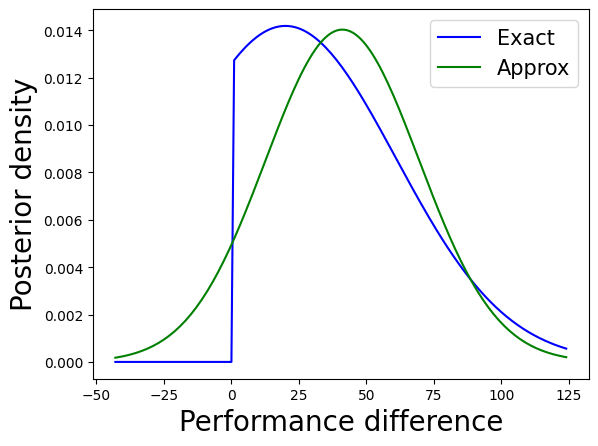

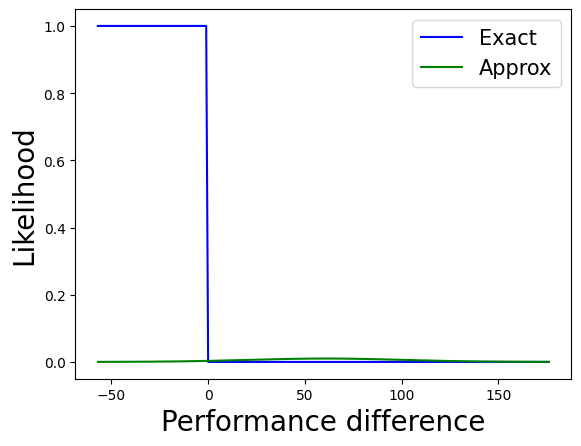

In [4]:
# the optimal approximation according to KL divergence but here is implicit
J_vs_F.plot_posterior_approx()

# This is not a numerical approximation, but it approximates the effect on the graph.
J_vs_F.plot_likelihood_approx()

## Three players game
We consider a third player, Steve. This time we create the pairwise confrontation from a ranking. To allow for draws, you need a positive `DRAW_MARGIN`

In [5]:
Fred = Player("Fred", rating_mu=100, rating_sigma2=25)
Jill = Player("Jill", rating_mu=120, rating_sigma2=1600)
Steve = Player("Steve", rating_mu=140, rating_sigma2=1600)

# set players first (winner) to last (loser)
# players draw if they are in the same tuple in the ranking
ranking = ((Jill, ), (Fred, ), (Steve,))

# tuple of players
players = sum(ranking, ())

# represent the performance differences between players
pairwise_list = get_pairwise_from_ranking(ranking)

for _ in range(1):
    for pairwise in pairwise_list:
        pairwise.expectation_propagation()
        pairwise.propagate()
    for player in players:
        print("Name:", player.name)
        print("The likelihood messages are:", player.likelihood_messages)
        print("The performance posterior after message is:",
                                                    player.perf_after_message)

for player in players:
    print("Name:", player.name)
    print("The approximated performance likelihood =", player.likelihood_perf)
    print("The approximated skill likelihood is =", player.likelihood_skill)
    player.update_rating()
    print("The new rating is:", str(player.skill)[1:])

Name: Jill
The likelihood messages are: [None, N(μ=160.8, σ²=1615.6)]
The performance posterior after message is: [N(μ=120.0, σ²=1625.0), N(μ=140.4, σ²=810.1)]
Name: Fred
The likelihood messages are: [N(μ=59.2, σ²=3190.6), N(μ=177.1, σ²=2043.4)]
The performance posterior after message is: [N(μ=99.4, σ²=49.2), N(μ=101.8, σ²=48.8)]
Name: Steve
The likelihood messages are: [N(μ=62.3, σ²=467.6), None]
The performance posterior after message is: [N(μ=79.7, σ²=363.1), N(μ=140.0, σ²=1625.0)]
Name: Jill
The approximated performance likelihood = N(μ=160.8, σ²=1615.6)
The approximated skill likelihood is = N(μ=160.8, σ²=1640.6)
The new rating is: (μ=140.1, σ²=810.0)
Name: Fred
The approximated performance likelihood = N(μ=131.1, σ²=1245.6)
The approximated skill likelihood is = N(μ=131.1, σ²=1270.6)
The new rating is: (μ=100.6, σ²=24.5)
Name: Steve
The approximated performance likelihood = N(μ=62.3, σ²=467.6)
The approximated skill likelihood is = N(μ=62.3, σ²=492.6)
The new rating is: (μ=80.6, 